<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.contingency_tables import cochrans_q

from scipy.stats import ttest_ind , chi2_contingency

#### ✅ 1.1 EDA & 결측치 및 이상치를 판단하고 설명

In [64]:
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv",index_col=0)
df = df.drop(columns = 'id', axis = 1)
df.head(3)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,male,27,1.80,87,no,no,always,3,sometimes,no,between 1 and 2 l,no,2 to 4,0 to 2,frequently,walking,overweight_level_i,26.851852
1,male,26,1.85,105,yes,yes,always,3,frequently,no,more than 2 l,no,2 to 4,>5,sometimes,public_transportation,obesity_type_i,30.679328
2,male,41,1.80,99,no,yes,sometimes,3,sometimes,no,between 1 and 2 l,no,2 to 4,3 to 5,frequently,automobile,obesity_type_i,30.555556


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0


통계표


,Age,Height,Weight,NCP,BMI
count,1262.000000,1262.000000,1262.000000,1262.000000,1262.000000
mean,25.749604,1.709184,101.083201,2.665610,34.439463
std,9.898088,0.091361,21.520848,0.757143,6.106623
min,15.000000,1.450000,53.000000,1.000000,22.826739
25%,21.000000,1.631576,82.000000,3.000000,30.725995
50%,24.000000,1.711095,105.000000,3.000000,34.332001
75%,27.000000,1.775768,116.000000,3.000000,38.920119
max,150.000000,1.980000,173.000000,4.000000,50.811753


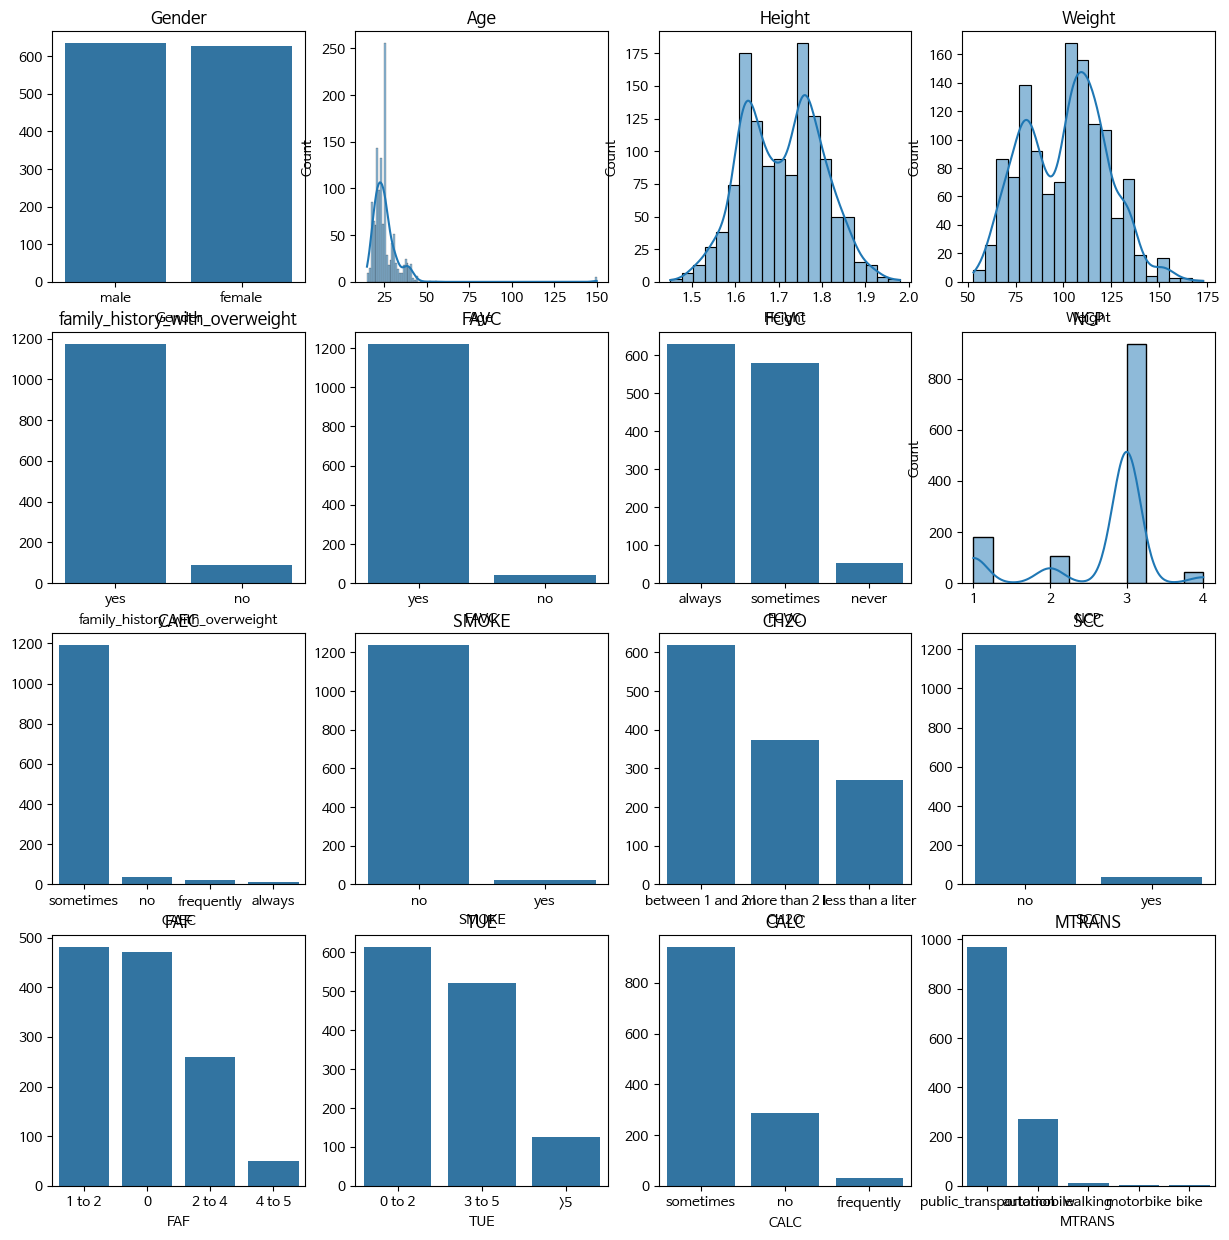

<Figure size 640x480 with 0 Axes>

In [65]:
# 결측치
display(df.isna().sum().to_frame().T)
# SCC 3

# 통계표
print("통계표")
display(df.describe())


# 분포도 그림
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

for i, axes in enumerate(axes.flat[:len(df.columns)]) :
  col_i = df.columns[i]

  if df[col_i].dtype == 'object' :
    target =  df[col_i].value_counts()
    sns.barplot(x= target.index, y = target.values, ax = axes)
    axes.set_title(col_i)

  else :
    sns.histplot(df[col_i], kde = True, ax = axes)
    axes.set_title(col_i)


plt.show()
plt.tight_layout()


수치형 변수들로만 상관 분석을 진행한 결과, BMI와 Weight는 강한 양의 상관관계를 보여 중복된 정보를 담고 있을 가능성이 있다.
이는 향후 모델링 시 다중공선성 문제를 일으킬 수 있으므로, 하나의 변수만 선택하는 것도 고려할 수 있다.
그 외 변수들 간에는 전반적으로 낮은 상관관계를 보여 변수 간 중복은 크지 않아보인다.



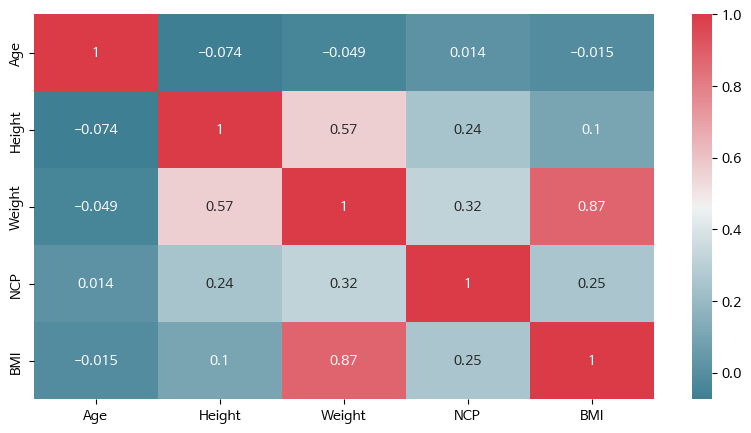

In [66]:
# 상관분석
num_col = df.select_dtypes(exclude = 'object').columns
cor_mat = df[num_col].corr()

plt.figure(figsize = (10,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cor_mat, cmap = cmap, annot= True)

print('''
수치형 변수들로만 상관 분석을 진행한 결과, BMI와 Weight는 강한 양의 상관관계를 보여 중복된 정보를 담고 있을 가능성이 있다.
이는 향후 모델링 시 다중공선성 문제를 일으킬 수 있으므로, 하나의 변수만 선택하는 것도 고려할 수 있다.
그 외 변수들 간에는 전반적으로 낮은 상관관계를 보여 변수 간 중복은 크지 않아보인다.
''')


Age에서 150살이라는 이상치가 나타나고 있으며, Weight 175라는 수치가 있지만 이는 고도 비만 일 수 있다는 점을 가만해
이상치로 보지 않는다. Age 컬럼의 이상치를 제거하도록 한다.



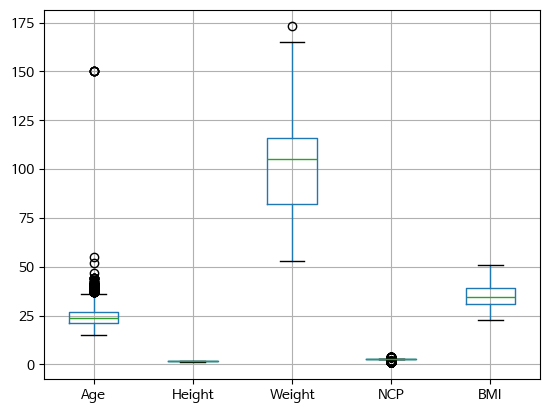

In [67]:
## 이상치

num_col = df.select_dtypes(exclude = 'object').columns
df[num_col].boxplot()
print('''
Age에서 150살이라는 이상치가 나타나고 있으며, Weight 175라는 수치가 있지만 이는 고도 비만 일 수 있다는 점을 가만해
이상치로 보지 않는다. Age 컬럼의 이상치를 제거하도록 한다.
''')

#### ✅ 1.2 데이터 전처리 기법 2가지를 설명하고 주어진 데이터에 적용시 어떤 효과가 있는지 설명

In [68]:

print(f'''
1. 결측치 처리 : 위의 EDA에서  SCC 변수에서 3개의 결측치가 있다. {df.shape[0]}의 ROw수에서 극소수를 차지하고 있기때문에
                 결측치를 단순제거한다. 결측치가 전체 데이터에서 차지하는 비율이 매우 낮은 경우, 이를 제거하는 것이
                 데이터의 왜곡이나 정보 손실에 큰 영향을 주지 않는다.
                 또한, 불완전한 데이터를 유지하며 대체값으로 채우는 것보다, 오히려 분석 결과의 신뢰성을 높이는 데 도움이 될 수 있다.
                 따라서 해당 결측치는 별도의 대체 없이 단순 삭제

2. 이상치 처리 : Age에서의 이상치를 제거하여, 이상치에 영향도를 줄인다.
3. 라벨 인코딩 : 범주형 데이터들은 서열척도로 간주 할 수 있다. 라벨 인코딩을 통해 서열척도를 살려, 순서 정보를 보존한 형태로 변환한다.
4. 스케일링 : 수치형 변수들의 단위 차이를 표준화 하여, 모델 학습시 변수간 영향력을 균등하게 만든다.

''')

# 1) 결측처리
df1 = df.dropna()

#2) 이상치 처리
df1 = df1[df1['Age'] < 100]

# 3) Scaling
ss = StandardScaler()
num_cols = df1.select_dtypes(exclude='object').columns
scaled_df = pd.DataFrame(ss.fit_transform(df1[num_cols]), columns=df1[num_cols].columns)

# 4) 라벨 인코딩
la = LabelEncoder()
for col in df1.select_dtypes(include='object').columns:
    df1[col] = la.fit_transform(df1[col]) + 1

# 5) 파생변수 제외할 수치형 칼럼 제거 후 결합
dummies_df = df1.drop(columns=['Age', 'Height', 'Weight', 'BMI'])

# 6) 최종 데이터 - index 문제가 있기 때문에 reset_index 꼭 실행해주기 shape가 안 맞음
r_df = pd.concat([scaled_df.reset_index(drop = True), dummies_df.reset_index(drop = True)], axis=1)

# 확인
print("dummies_df shape:", dummies_df.shape)
print("scaled_df shape:", scaled_df.shape)
print("r_df shape:", r_df.shape)


1. 결측치 처리 : 위의 EDA에서  SCC 변수에서 3개의 결측치가 있다. 1262의 ROw수에서 극소수를 차지하고 있기때문에
                 결측치를 단순제거한다. 결측치가 전체 데이터에서 차지하는 비율이 매우 낮은 경우, 이를 제거하는 것이
                 데이터의 왜곡이나 정보 손실에 큰 영향을 주지 않는다.
                 또한, 불완전한 데이터를 유지하며 대체값으로 채우는 것보다, 오히려 분석 결과의 신뢰성을 높이는 데 도움이 될 수 있다.
                 따라서 해당 결측치는 별도의 대체 없이 단순 삭제

2. 이상치 처리 : Age에서의 이상치를 제거하여, 이상치에 영향도를 줄인다.
3. 라벨 인코딩 : 범주형 데이터들은 서열척도로 간주 할 수 있다. 라벨 인코딩을 통해 서열척도를 살려, 순서 정보를 보존한 형태로 변환한다.
4. 스케일링 : 수치형 변수들의 단위 차이를 표준화 하여, 모델 학습시 변수간 영향력을 균등하게 만든다.


dummies_df shape: (1254, 14)
scaled_df shape: (1254, 5)
r_df shape: (1254, 19)


#### ✅ 1-3 피쳐 엔지니어링을 통해 파생변수 1개를 생성하고 그 이유

In [69]:
# Activity_Index (활동지수)
# FAF (신체활동 빈도) + TUE(여가 시간 활동)

r_df['Activity_Index'] = r_df['FAF'] + r_df['TUE']

print('''
활동 지수는 BMI나 NObeyesdad와 유의미한 상관관계를 가질 가능성이 높다.
''')


활동 지수는 BMI나 NObeyesdad와 유의미한 상관관계를 가질 가능성이 높다.



#### ✅ 2-1 앙상블을 제외한 분류 모델 3가지 구축 및 결과 비교 및 설명





In [70]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score, recall_score

print('''
✅ 1. Support Vector Machine (SVC)
SVM은 고차원 공간에서 클래스 간 분리를 잘 수행하는 모델
특히 변수 간 상호작용이 비선형적일 때 커널 기법을 통해 복잡한 결정 경계를 생성
이 데이터는 BMI, FAF, CALC, CH2O, family_history_with_overweight 등 다양한 변수들이 있고,
단순 선형으로 분리되지 않을 수 있기 때문에, SVM은 복잡한 패턴을 효과적으로 학습

✅ 2. K-Nearest Neighbors (KNN)
KNN은 비모수(non-parametric) 모델로, 학습 대신 예측 시 데이터를 비교
이 모델은 변수 스케일에 민감하기 때문에 StandardScaler로 스케일링이 필수이며, 데이터는 이미 스케일 조정 전제 하에 잘 적용
데이터의 분포를 직접 반영하며, 복잡한 결정 경계도 따라갈 수 있는 장점

✅ 3. Naive Bayes (GaussianNB)
GaussianNB는 각 피처가 정규분포를 따른다고 가정하며, 계산이 빠르고 적은 데이터에도 잘 작동
현재 데이터는 일부 전처리된 연속형 변수(BMI, CH2O 등)와 정수형으로 변환된 범주형 변수들이 섞여 있으며,
Naive Bayes의 단순 가정이 잘 맞을 가능성이 있는 구조
또한, 다중 클래스 분류에 자연스럽게 적용 가능하고, 설명력 있는 모델 비교 기준
''')


✅ 1. Support Vector Machine (SVC)
SVM은 고차원 공간에서 클래스 간 분리를 잘 수행하는 모델
특히 변수 간 상호작용이 비선형적일 때 커널 기법을 통해 복잡한 결정 경계를 생성
이 데이터는 BMI, FAF, CALC, CH2O, family_history_with_overweight 등 다양한 변수들이 있고,
단순 선형으로 분리되지 않을 수 있기 때문에, SVM은 복잡한 패턴을 효과적으로 학습

✅ 2. K-Nearest Neighbors (KNN)
KNN은 비모수(non-parametric) 모델로, 학습 대신 예측 시 데이터를 비교
이 모델은 변수 스케일에 민감하기 때문에 StandardScaler로 스케일링이 필수이며, 데이터는 이미 스케일 조정 전제 하에 잘 적용
데이터의 분포를 직접 반영하며, 복잡한 결정 경계도 따라갈 수 있는 장점

✅ 3. Naive Bayes (GaussianNB)
GaussianNB는 각 피처가 정규분포를 따른다고 가정하며, 계산이 빠르고 적은 데이터에도 잘 작동
현재 데이터는 일부 전처리된 연속형 변수(BMI, CH2O 등)와 정수형으로 변환된 범주형 변수들이 섞여 있으며,
Naive Bayes의 단순 가정이 잘 맞을 가능성이 있는 구조
또한, 다중 클래스 분류에 자연스럽게 적용 가능하고, 설명력 있는 모델 비교 기준



In [71]:
y = r_df['NObeyesdad']
X = r_df.drop(columns = 'NObeyesdad', axis = 1)

def modeling(model, name) :
  x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 2344)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  precision = precision_score(y_test, pred, average = 'weighted')   #  다중 클래스 (multiclass) 인 경우"binary" 평균 방식은 사용 X
  recall = recall_score(y_test, pred, average = 'weighted')   #  다중 클래스 (multiclass) 인 경우"binary" 평균 방식은 사용 X
  accuracy = accuracy_score(y_test, pred)

  return precision, recall, accuracy

lst = []
for name, model in [['SVC', SVC()], ['KN' , KNeighborsClassifier()], ['GNB' , GaussianNB()]] :
  precision, recall, accuracy  = modeling(model, name)
  lst.append([name, precision, recall, accuracy])

display(pd.DataFrame(lst, columns = ['name', 'precision', 'recall', 'accuracy']))
print('''
1. 정밀도 (Precision) - 맞다고 판단한 것들 중 실제로 맞은 비율
2. 재현율 (Recall) - 실제 양성인 것을 양성으로 예측한 비율
3. 정확도 (Accuracy) - 전체 중, 정확히 맞춘 비율
이 세 가지를 비교 할때 SVC모델이 고차원적 특성을 잘 반영해 복잡한 결정 계수를 학습했기 때문이라고 보이며,
전반적으로 매우 정확하고 안정적인 모델로 확인된다.
''')

,name,precision,recall,accuracy
0,SVC,0.979300,0.978780,0.978780
1,KN,0.921170,0.917772,0.917772
2,GNB,0.903947,0.867374,0.867374



1. 정밀도 (Precision) - 맞다고 판단한 것들 중 실제로 맞은 비율
2. 재현율 (Recall) - 실제 양성인 것을 양성으로 예측한 비율
3. 정확도 (Accuracy) - 전체 중, 정확히 맞춘 비율
이 세 가지를 비교 할때 SVC모델이 고차원적 특성을 잘 반영해 복잡한 결정 계수를 학습했기 때문이라고 보이며,
전반적으로 매우 정확하고 안정적인 모델로 확인된다.



#### ✅ 2-2 사용한 모델 중 하나를 골라 그리드 서치를 통해서 파라미터 튜닝 및 분류 모델 성능 평가 (precision ,recall)


In [72]:
svc = SVC()

param = {
    'C' : [0.1, 1, 10] ,
    'kernel' :['rbf','linear'],
    'gamma' : ['scale', 'auto'],
    'degree' : [2,3]
}

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 2344)

grid_search = GridSearchCV(svc, param, cv = 5, scoring = 'accuracy')
grid_search.fit(x_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

best_grid = grid_search.best_estimator_
best_grid.fit(x_train, y_train)
best_pred = best_grid.predict(x_test)

precision = precision_score(y_test, best_pred, average = 'weighted')
recall = recall_score(y_test, best_pred, average = 'weighted')

print(f'정밀도 : {precision}')
print(f'재현율 : {recall}')


{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.9965779220779221
정밀도 : 0.9895250596796376
재현율 : 0.9893899204244032


#### ✅ 2-3.  3가지 모델을 soft voting을 이용하여 모델링 한 결과와 2-2의 결과와 비교


In [73]:
print('''
Soft-Voting - 각 모델의 예측 확률의 평균을 내어, 가장 확률이 높은 클래스를 최종 예측으로 선택하는 방식
              여러 모델의 예측 확률을 종합해서 , 더 똑똑한 결정을 내림, 단순한 다수결의 하드 보팅 보다 정교한 예측이 가능
''')


Soft-Voting - 각 모델의 예측 확률의 평균을 내어, 가장 확률이 높은 클래스를 최종 예측으로 선택하는 방식
              여러 모델의 예측 확률을 종합해서 , 더 똑똑한 결정을 내림, 단순한 다수결의 하드 보팅 보다 정교한 예측이 가능



In [74]:
from sklearn.ensemble import VotingClassifier

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 2344)

soft_vote = VotingClassifier(estimators=   [('SVC', SVC(probability=  True)),
                                            ('KN' , KNeighborsClassifier()),
                                            ('GNB' , GaussianNB())] ,
                            voting = 'soft')


soft_vote.fit(x_train, y_train)
soft_pred = soft_vote.predict(x_test)

precision = precision_score(y_test, soft_pred, average = 'micro')
recall = recall_score(y_test, soft_pred, average = 'micro')

print(f'정밀도 : {precision}')
print(f'재현율 : {recall}')

정밀도 : 0.9575596816976127
재현율 : 0.9575596816976127


#### ✅ 2-4 하나의 모델을 선정하여 Drop Column Importance 방식으로 각 변수 별로 전체 컬럼을 포함한 모델과의 recall 값의 차이를 계산하고 시각화


Recall 감수량이 클수록 모델 성능에 중요한 기여를 한 것으로 BMI, Gender, NCP, Weight 가 모델 선으에 중요한 기여를 한 것으로 해석
음수인 경우는 모델에 중요하지 않거나, 방해요인으로 해석되며, FCVC, FACV, CH20, MTRANS, CALC 컬럼의 경우 중요도가 낮다고 해석된다.



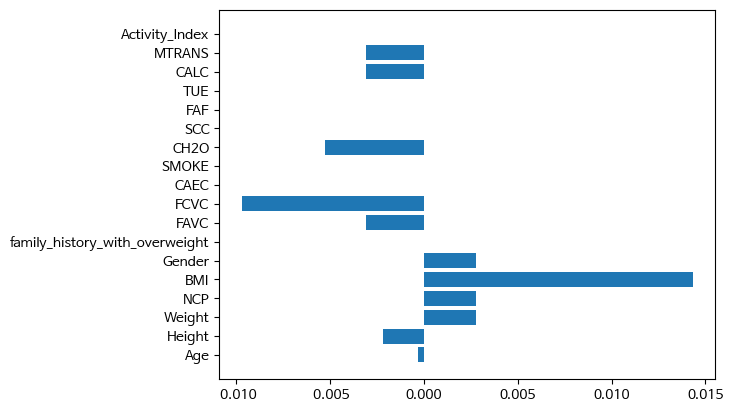

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 전체 피처로 학습한 베이스라인 모델
base_model = SVC()
base_model.fit(X_train, y_train)
base_pred = base_model.predict(X_test)

# baseline recall (다중 클래스니까 average 설정!)
baseline_recall = recall_score(y_test, base_pred, average='macro')

#--- Drop columns 계산

lst = {}
for col in X.columns :
  X_train_drop = X_train.drop(columns = [col])
  X_test_drop  = X_test.drop(columns = [col])

  model = SVC()
  model.fit(X_train_drop, y_train)
  drop_rped = model.predict(X_test_drop)

  drop_recall = recall_score(y_test, drop_rped, average = 'macro')
  drop_value = baseline_recall - drop_recall
  lst[col] = drop_value


drop_df = pd.DataFrame(lst.items(), columns = ['columns','drop_value'])

plt.barh(drop_df['columns'] , drop_df['drop_value'])

print('''
Recall 감수량이 클수록 모델 성능에 중요한 기여를 한 것으로 BMI, Gender, NCP, Weight 가 모델 선으에 중요한 기여를 한 것으로 해석
음수인 경우는 모델에 중요하지 않거나, 방해요인으로 해석되며, FCVC, FACV, CH20, MTRANS, CALC 컬럼의 경우 중요도가 낮다고 해석된다.
''')

#### ✅ 3.1 아래의 기준으로 전처리를 하여 적정 체중 여부 컬럼을 생성하고 BMI를 5단위로 구분하여 와 적정 체중여부에 대한 빈도 표를 만들어라
    bmi 계산 - Bmi = 몸무게(kg)/(키(m)**2)

    만나이 구하기 - 건강검진을 받았던 날을 기준으로 생년월일과 일수 차이가 16년 364일 이하인 경우 만 16세 그 이상의 경우 만 17로 분류하라 - 윤년 등은 고려하지 않는다. 햇수로 16년 + 일수로 364일이 기준이다

    적정 체중 여부 (BMI가 아래 구간에 들어올 경우)
    17세 남자 : 21.03이상 23.21 미만
    17세 여자 : 20.03이상 22.39 미만
    16세 남자 : 21.18이상 23.45 미만
    16세 여자 : 19.61이상 21.74 미만

In [76]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv')
df.head(3)

,ID,키,weight,생년월일,건강검진일,공학여부,채소섭취정도,아침식사여부,일주일운동시간,수면시간,성별
0,ID_4135,169.01,65.47,20041003,2020_11_15,1,2,1,4.4,8.3,남성
1,ID_3289,181.62,69.36,19970725,2014_11_20,0,3,0,4.4,6.9,남성
2,ID_1847,160.89,65.12,20020921,2020_01_28,1,1,1,1.7,9.6,여성


In [77]:
# BMI 계산
df['bmi'] = df['weight'] / (df['키'] /100) **2

In [78]:
# 만나이
# 1) 비교 날짜 생성 생년월일의 "월일" + 건강검진일의 "년" 을 합쳐 year 변수 생성
#df['new_year'] =
df['new_year'] = pd.to_datetime(df['건강검진일'].str.split('_').str[0] +'-' +df['생년월일'].astype(str).str[4:], format = '%Y-%m%d')




In [79]:

df['생년월일'] = pd.to_datetime(df['생년월일'], format = '%Y%m%d')
df['건강검진일'] = pd.to_datetime(df['건강검진일'], format = '%Y_%m_%d')


# 년도 차이 = 16년 생년월일 VS 건강검진일
df['year_diff'] = df['건강검진일'].dt.year - df['생년월일'].dt.year

# 일 차이 = 16년 생년월일 VS 건강검진일
df['day_diff'] = (df['건강검진일'] - df['new_year']).dt.days


# 만나이 구하기
# 햇수로 16년 - 17이상이면 17
# 16이고, 364일보다 크면 17

def ages(df) :
  year_diff = df['year_diff']
  day_diff = df['day_diff']

  if year_diff >= 17 :
    return 17

  elif year_diff == 16 and day_diff > 364 :
    return 17

  else :
    return 16

df['만나이'] = df.apply(ages, axis = 1)#.value_counts()

In [80]:
# 적정체중여부

def is_normal(df) :
  age = df['만나이']
  gender = df['성별']
  bmi = df['bmi']

  if age >= 17 and gender == '남성' :
    if 21.03 <= bmi < 23.21 :
      return '정상'
    else :
      return '비정상'

  elif age >= 17 and gender == '여성' :
    if 20.03 <= bmi < 22.39 :
      return '정상'
    else :
      return '비정상'

  elif age ==16 and gender == '남성' :
    if 21.18 <= bmi < 23.45 :
      return '정상'
    else :
      return '비정상'

  elif age ==16  and gender == '여성' :
    if 19.61 <= bmi < 21.74 :
      return '정상'
    else :
      return '비정상'

df['적정체중여부'] = df.apply(is_normal, axis = 1)

#### ✅ 3.2 3-1에서 구한 적정 체중 여부와 나머지 컬럼(공학여부, 아침식사여부, 일주일운동시간, 채소섭취정도, 수면시간, 성별) 이 독립적인지 통계적으로 확인

In [81]:
cols = ['공학여부' ,'아침식사여부','일주일운동시간', '수면시간' ,'채소섭취정도' ,'성별']

lst = []
for col in cols :
  if col in ['공학여부' , '채소섭취정도' ,'성별' ,'아침식사여부'] :
    target = pd.crosstab(df[col], df['적정체중여부'])
    stat, p_val, dof, expected = chi2_contingency(target)

  else :
    g1 = df[df['적정체중여부'] == '정상'][col]
    g2 = df[df['적정체중여부'] == '비정상'][col]

    stat, p_val = ttest_ind(g1, g2, equal_var = True)

  lst.append([col, p_val])

pd.DataFrame(lst, columns = ['col','p_val'])

,col,p_val
0,공학여부,0.028622
1,아침식사여부,0.545861
2,일주일운동시간,0.526151
3,수면시간,0.008380
4,채소섭취정도,0.024652
5,성별,0.356966


#### ✅ 3.3 위에서 유의한 변수들만 가지고 적정 체중 여부를 예측하는 모델을 구현하고 성능 평가 및 해석을 하라 (로지스틱회귀 ,xgb)

    로지스틱회귀 모델은 오즈비를 구하라 xgb의 경우 각 피쳐중요도를 확인하고 예측에 영향을 가장 미치는 변수를 확인하라

In [82]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

r_df = df[['공학여부','수면시간','채소섭취정도','적정체중여부']]
r_df['적정체중여부'] = r_df['적정체중여부'].map({'정상': 1, '비정상':0})

x = r_df.drop(columns = '적정체중여부', axis = 1)
y = r_df['적정체중여부']

def eval_model(model, name) :
  x_train, x_test, y_train, y_test= train_test_split(x, y, test_size = 0.3, random_state = 13)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  acc = accuracy_score(y_test, pred)

  return acc


lst = []
model_lst = []

for name, model in [['LR', LogisticRegression()] , ['XGB',XGBRFClassifier() ]] :
  acc = eval_model(model, name)
  lst.append([name, acc])
  model_lst.append([name, model])

res = pd.DataFrame(lst, columns = ['Models', 'Accuracy_score'])
display(res)

,Models,Accuracy_score
0,LR,0.578148
1,XGB,0.571779


array([1.12977424, 1.04815121, 0.99961824])

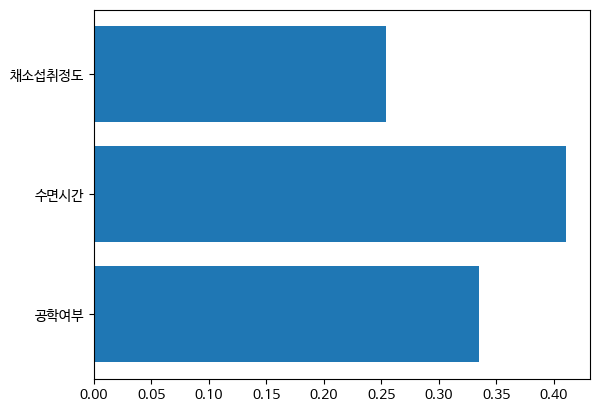

In [83]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

for name , model in model_lst :
  if name == 'LR' :
    odds_ratio = np.exp(model.coef_[0]) # 오즈비
    display(odds_ratio)

  elif name == 'XGB' :
    importance = model.feature_importances_
    features = model.feature_names_in_

    plt.barh(features, importance)

#### ✅ 3.4 두 모델의 roc-auc 그래프를 하나의 그래프에 겹쳐 그려라

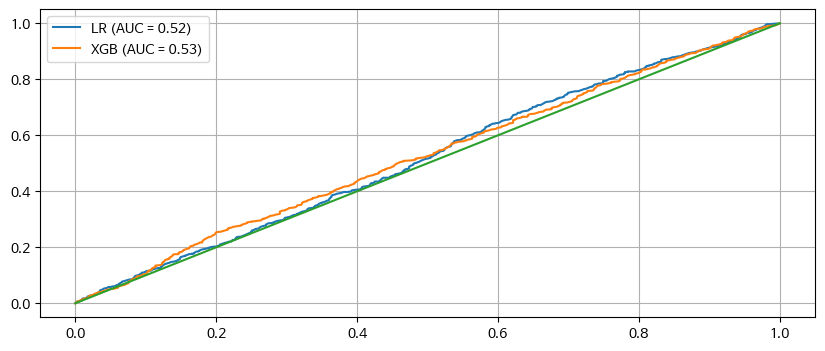

In [84]:
r_df = df[['공학여부','수면시간','채소섭취정도','적정체중여부']]
r_df['적정체중여부'] = r_df['적정체중여부'].map({'정상': 1, '비정상':0})

x = r_df.drop(columns = '적정체중여부', axis = 1)
y = r_df['적정체중여부']

# plot
plt.figure(figsize=(10, 4))

def eval_model(model, name) :
  x_train, x_test, y_train, y_test= train_test_split(x, y, test_size = 0.3, random_state = 13)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  # Roc_Cure용 - predict_proba[:,1]
  pred_proba = model.predict_proba(x_test)[:,1]

  acc = accuracy_score(y_test, pred)
  # Roc_Cure용
  auc = roc_auc_score(y_test, pred_proba)
  # ROC Curve
  fpr, tpr, _ = roc_curve(y_test, pred_proba)
  plt.plot(fpr, tpr, label = f'{name} (AUC = {auc:.2f})')

  return acc

## eval_model 호출
lst = []
for name, model in [['LR', LogisticRegression()] , ['XGB',XGBRFClassifier() ]] :
  acc = eval_model(model, name)
  lst.append([name, acc])

plt.plot([0,1],[0,1])
plt.grid(True)
plt.legend()
plt.show()

#### 📊 통계 (40점)
##### ✅ 1. 어느 회사의 제품 무게는 N(?, 100) 의 정규분포를 따른다고 알려져 있다. 이때, 사전적으로 우리는 제품의 평균 무게 가 정규분포 N(100, 256) 에서 온다고 가정한다. 제품 중 하나의 실제 측정된 무게가 120kg일 때, 이 정보를 바탕으로 사후분포의 평균을 구하시오.

In [85]:
# N(100, 256) - 평균 100, 분산 256 / 표준편차 16

x = 100   #사전평균
var = 256  #사전분산

x_obs = 120    #관측값
var_obs = 100  #제품의 무게의 분산

# 사후 분포 평균 계산공식 (사전평균/사전분산 + 관측값/분산) / (1/사전분산 + 1/제품의분산)
mean = (x/var + x_obs /var_obs) / (1/var + 1/var_obs)
print(mean)

# 사후 분포 분산
var = 1 / (1/var + 1/var_obs)
print(var)

114.3820224719101
71.91011235955057


##### ✅ 2.1 회귀 모델링 후 유의하지 않는변수 파악

In [86]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_5_advertising.csv')
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [87]:
import statsmodels.api as sm

x = df.drop(columns = ['Sales'], axis = 1)
y = df['Sales']

add_x = sm.add_constant(x)
model = sm.OLS(y, add_x).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     605.4
Date:                Tue, 01 Apr 2025   Prob (F-statistic):           8.13e-99
Time:                        13:07:35   Log-Likelihood:                -383.34
No. Observations:                 200   AIC:                             774.7
Df Residuals:                     196   BIC:                             787.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6251      0.308     15.041      0.0

##### ✅ 2.2 변수 선택시 먼저 제거 될 변수 및 근거 제시

In [88]:
print('''
먼저 제거 되어야하는 변수는 Newspapaer 로 p_value 0.954로 Sales에 유의미한 영향을 주지 않는다.
''')


먼저 제거 되어야하는 변수는 Newspapaer 로 p_value 0.954로 Sales에 유의미한 영향을 주지 않는다. 



##### ✅ 2.3 VIF를 통한 다중공선성 진단

In [89]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Features']= x.columns

vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif)

    Features       VIF
0         TV  2.486772
1      Radio  3.285462
2  Newspaper  3.055245


✅ 2.4  A,B,C,D,E 영업사원의 각 계약 성사 유무 (1:계약 , 0:미계약) 를 나타낸 데이터이다. 영업사원의 평균 계약 성사 건수는 같은지 통계 검정

In [93]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv',index_col = 0)
df.head(3)

# 귀무 : 영업 사원의 평균 계약 성사 건수는 같다.
# 대립 : 영업 사원의 평균 계약 성사 건수는 다르다.

from statsmodels.stats.contingency_tables import cochrans_q

coch= cochrans_q(df)
print(coch.pvalue)

if coch.pvalue < 0.05 :
  print('영업 사원의 평균 계약 성사 건수는 다르다')

else :
  print('영업 사원의 평균 계약 성사 건수는 같다.')

0.3406392758219471
영업 사원의 평균 계약 성사 건수는 같다.
